# GP testing

In [1]:
import os
import csv
import sys
import torch
import pickle
import gpytorch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch import optim
from torch.utils import data
from torchvision import transforms
from torch.nn import functional as F
from gpytorch.kernels import RBFKernel, ScaleKernel, AdditiveKernel

In [2]:
# we need to manually add the project directory to the path when using Jupyter notebooks
sys.path.append("/home/santeri/repos/HIT_VAE")

In [3]:
from hit_vae.models import mnist_conv_vae
from hit_vae.models import losses
from hit_vae.utils import data_loading
from hit_vae.utils import plotting
from hit_vae.basic_kernels.constant_kernel import ConstantKernel
from hit_vae.basic_kernels.categorical_kernel import CategoricalKernel
from hit_vae.basic_kernels.input_warping_kernel import InputWarpKernel

In [4]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu:0'
print(f'using device: {device}')

using device: cpu:0


## Data

For testing we use a two-component Gaussian mixture model

In [5]:
data_a = np.random.multivariate_normal(mean = [0, 0], cov=[[1, 0], [0, 1]], size=10)
data_b = np.random.multivariate_normal(mean = [4, 2], cov=[[1, 0], [0, 1]], size=10)
data_c = np.random.multivariate_normal(mean = [5, -1], cov=[[0.5, 0], [0, 0.5]], size=10)

data = np.concatenate((data_a, data_b, data_c), axis = 0)

id = np.repeat(np.array([0, 1, 2]), [10, 10, 10], axis=0)# + np.random.normal(loc=0.0, scale=0.05, size=300)

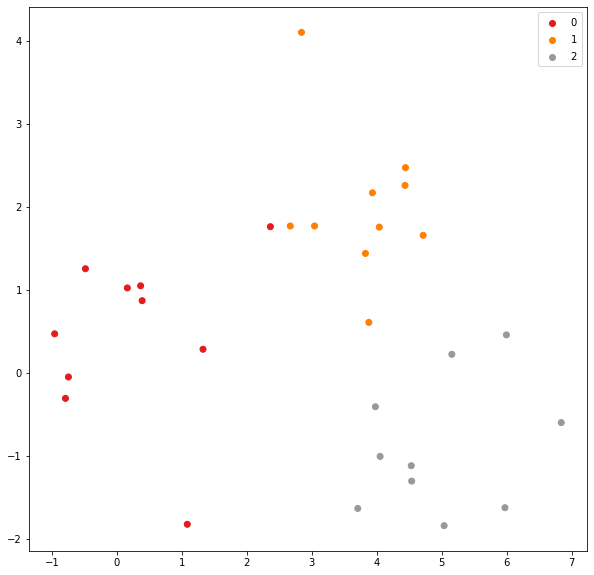

In [6]:
plotting.visualize_latent_2D(data, id)

In [7]:
Z = torch.tensor(data, dtype=torch.float).to(device)
labels = torch.tensor(id, dtype=torch.float).view(-1, 1).to(device)

In [8]:
print(labels)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]])


## GP model

In [9]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, covar_module):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = covar_module
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
#covar_module = ScaleKernel(ConstantKernel(active_dims=0)) * CategoricalKernel(active_dims=0)
#covar_module = ScaleKernel(CategoricalKernel())
covar_module = ScaleKernel(RBFKernel(active_dims=0))

In [11]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

In [12]:
train_x = Z[:, 0].view(-1)
train_y = Z[:, 1].view(-1)

In [13]:
print(train_x)

tensor([-0.7454, -0.9571,  1.0834,  0.3886, -0.7915,  2.3623,  0.1609, -0.4840,
         1.3253,  0.3654,  4.7123,  4.4409,  2.6677,  4.0376,  3.9325,  4.4340,
         3.8245,  3.0418,  3.8771,  2.8403,  5.9709,  3.7066,  6.8371,  5.1538,
         5.9936,  4.5296,  4.0504,  4.5359,  3.9777,  5.0354])


In [14]:
gp_x = ExactGPModel(labels, train_x, likelihood, covar_module).to(device)
gp_y = ExactGPModel(labels, train_y, likelihood, covar_module).to(device)

In [15]:
gp_x

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (quadrature): GaussHermiteQuadrature1D()
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

## Training the model

In [16]:
gp_x_optimizer = optim.Adam([ {'params': gp_x.parameters()},], lr=0.01)
gp_y_optimizer = optim.Adam([ {'params': gp_y.parameters()},], lr=0.01)

In [17]:
mll_x = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_x)
mll_y = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_y)

In [18]:
for param_name, param in gp_x.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [19]:
training_iter = 500

for i in range(training_iter):
    # Zero gradients from previous iteration
    gp_x_optimizer.zero_grad()
    gp_y_optimizer.zero_grad()
    
    # Output from model
    output_x = gp_x(labels)
    output_y = gp_y(labels)
    
    #print(output_x)
    #print(train_x.shape)
    
    # Calc loss and backprop gradients
    loss_x = -mll_x(output_x, train_x)
    loss_y = -mll_y(output_y, train_y)
    
    loss = loss_x + loss_y
    
    loss.mean().backward()
    if i % 50 == 0:
        print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            #gpmodel.covar_module.base_kernel.lengthscale.item(),
            gp_x.likelihood.noise.item()
        ))
    gp_x_optimizer.step()
    gp_y_optimizer.step()

Iter 1/500 - Loss: 3.633  noise: 0.693
Iter 51/500 - Loss: 3.259  noise: 0.901
Iter 101/500 - Loss: 3.157  noise: 0.870
Iter 151/500 - Loss: 3.111  noise: 0.865
Iter 201/500 - Loss: 3.086  noise: 0.863
Iter 251/500 - Loss: 3.070  noise: 0.861
Iter 301/500 - Loss: 3.059  noise: 0.861
Iter 351/500 - Loss: 3.051  noise: 0.860
Iter 401/500 - Loss: 3.044  noise: 0.860
Iter 451/500 - Loss: 3.039  noise: 0.860


In [20]:
for param_name, param in gp_x.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.30891045928001404
Parameter name: mean_module.constant                       value = 2.5054736137390137
Parameter name: covar_module.raw_outputscale               value = 2.567735433578491
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -1.0764998197555542


In [21]:
gp_x.eval()
gp_y.eval()

test_ids = np.repeat(np.array([0, 1, 2]), [5, 5, 5], axis=0)
test_labels = torch.tensor(test_ids, dtype=torch.float)

pred_x = likelihood(gp_x(test_labels))
pred_y = likelihood(gp_y(test_labels))

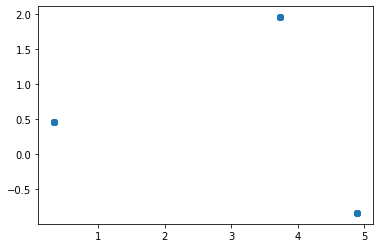

In [22]:
plt.scatter(pred_x.mean.detach().cpu().numpy(), pred_y.mean.detach().cpu().numpy())